# AIR Homework 1 - Pick and Place

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

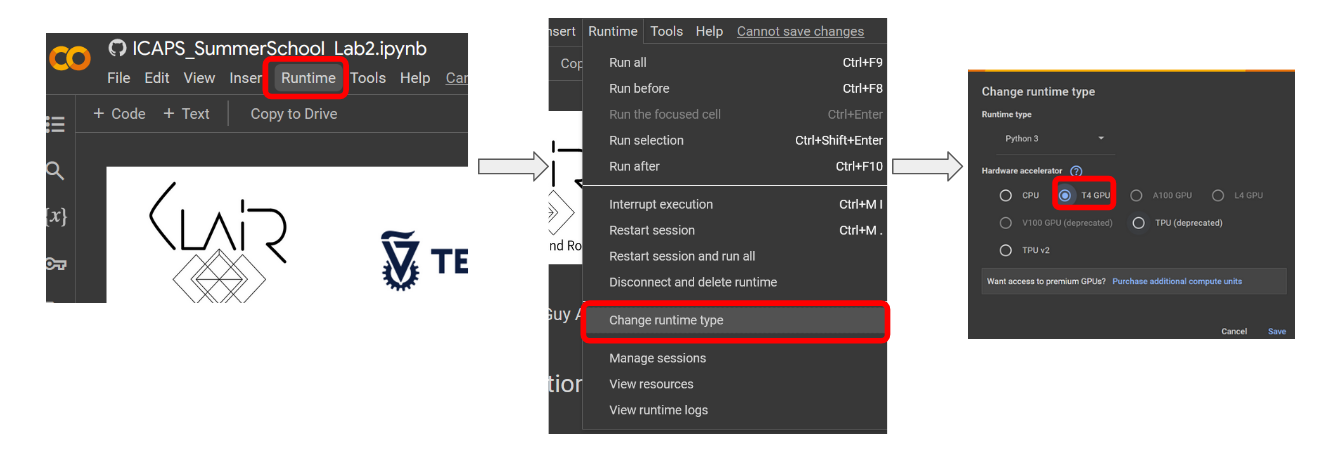

## Assignment Overview

For your first assignment, you will implement a pick-and-place task using Everything you learned (and will learn) in class. The goal is to pick up the red box and place it in the green bin without knocking over any obstacles. You will implement a full pipeline that includes control, motion planning, and perception.

You will implement the following components:
1. **PID Control**: Implement a PID controller to control the robot's end-effector position and orientation.
2. **Motion Planning During Manipulation**: Use a motion planning algorithm (e.g., RRT, PRM) to plan a path for the robot to pick up the red box and place it in the green bin while avoiding obstacles.
3. **Perception with Belief**: Utilize computer vision techniques to maintain a belief over the positions of the red box and green bin.
4. **Integration**: Integrate all components into a cohesive system that can perform the pick-and-place task in a simulated environment.

## Setup

In [1]:
# install required packages
!pip install mujoco
!pip install mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

# Enable GPU rendering in Colab
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU.\n'
    'Make sure you are using a GPU Colab runtime.\n'
    'Go to the Runtime menu and select Choose runtime type.\n'
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)
  
# Set the EGL backend for MuJoCo
import platform

is_apple_silicon = platform.system() == "Darwin" and platform.processor() == "arm"
if not is_apple_silicon:
  %env MUJOCO_GL=egl

Cannot communicate with GPU.
Make sure you are using a GPU Colab runtime.
Go to the Runtime menu and select Choose runtime type.
You can also skip this and use CPU with slower rendering.


## Our Working Environment

Our environment consists of our usual table, red box, and UR5e. However, there are a few modifications to make the task more challenging.
1. We have added a stationary green bin to serve as the target location for the red box.
2. We have introduced four movable obstacles on the table to increase the complexity of the motion planning task.
3. The UR5e robot has been equipped with a gripper to facilitate the pick-and-place operation.
4. The UR5e robot now uses velocity actuation instead of position actuation, making it harder to control

In [2]:
!git clone https://github.com/google-deepmind/mujoco_menagerie
(robot_path,) = !find mujoco_menagerie -name "ur5e.xml"
(gripper_path, _) = !find mujoco_menagerie -name "2f85.xml"
print(f"UR5e robot MJCF path: {robot_path}\n")
print(f"Gripper MJCF path: {gripper_path}\n")

xml = """
<mujoco model="tableworld">
    <statistic center="0.3 0 0.4" extent="0.8"/>

    <visual>
        <headlight diffuse="0.6 0.6 0.6" ambient="0.1 0.1 0.1" specular="0 0 0"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <global azimuth="45" elevation="-20"/>
    </visual>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
                 markrgb="0.8 0.8 0.8" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
    </asset>

    <worldbody>
        <light pos="0 0 1.5" dir="0 0 -1" directional="true"/>
        <geom name="floor" pos="0.0 0.0 0.0" size="0 0 0.05" type="plane" material="groundplane"/>

        <body name="table" pos="0.3 0.0 0">
            <geom name="table_top" type="box" size=".37 .37 .01" pos="0 0 .7"/>
            <geom name="table_leg_1" type="cylinder" size=".01 .7" pos=".24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_2" type="cylinder" size=".01 .7" pos=".24 .24 -.0" euler="0 0 0"/>
            <geom name="table_leg_3" type="cylinder" size=".01 .7" pos="-.24 -.24 -.0" euler="0 0 0"/>
            <geom name="table_leg_4" type="cylinder" size=".01 .7" pos="-.24 .24 -.0" euler="0 0 0"/>
        </body>

        <body name="red_box" pos="0.3 -0.2 0.75">
            <freejoint/>
            <geom name="red_box_geom" type="box" size=".03 .03 .03" rgba="1 0 0 1"/>
        </body>
        <body name="green_bin" pos="0.45 0.25 0.71">
            <geom name="green_bin_bottom" type="box" size=".08 .08 .01" rgba="0 1 0 1"/>
            <geom name="green_bin_left_wall" type="box" size=".08 .01 .08" rgba="0 1 0 1" pos="0 -0.08 0.04"/>
            <geom name="green_bin_right_wall" type="box" size=".08 .01 .08" rgba="0 1 0 1" pos="0 0.08 0.04"/>
            <geom name="green_bin_back_wall" type="box" size=".01 .08 .08" rgba="0 1 0 1" pos="-0.08 0 0.04"/>
            <geom name="green_bin_front_wall" type="box" size=".01 .08 .08" rgba="0 1 0 1" pos="0.08 0 0.04"/>
        </body>

        <body name="obstacle1" pos="0.1 0.3 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle2" pos="0.1 -0.3 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle3" pos="0.55 0.05 1.01">
            <freejoint/>
            <geom type="box" size=".025 .025 .3"  rgba="0 0 1 1"/>
        </body>
        <body name="obstacle4" pos="0.3 0 0.81">
            <freejoint/>
            <geom type="box" size=".025 .025 .1"  rgba="0 0 1 1"/>
        </body>

        <!--angle view-->
        <camera name="rightangleview" pos="2.182 1.724 2.590" xyaxes="-0.685 0.729 0.000 -0.456 -0.429 0.780"/>
        <camera name="leftangleview" pos="2.182 -1.724 2.590" xyaxes="0.685 0.729 0.000 -0.456 0.429 0.780"/>
        <!-- front view -->
        <camera mode="fixed" name="frontview" pos="2.5 0 1.45" quat="0.56 0.43 0.43 0.56"/>
        <!-- bird view -->
        <camera mode="fixed" name="birdview" pos="0.3 0 3.0" quat="0.7071 0 0 0.7071"/>
        <!-- side view -->
        <camera mode="fixed" name="leftsideview" pos="0.151 -2.941 0.9" xyaxes="1.000 0.000 0.000 0.000 0.000 1.000"/>
        <camera mode="fixed" name="rightsideview" pos="0.151 2.941 0.9" xyaxes="-1.000 0.000 0.000 0.000 0.000 1.000"/>

    </worldbody>

</mujoco>
"""

import mujoco
import mediapy as media

scene_spec = mujoco.MjSpec.from_string(xml)
robot_spec = mujoco.MjSpec.from_file(robot_path)
gripper_spec = mujoco.MjSpec.from_file(gripper_path)

for act in robot_spec.actuators:
    act.gaintype = mujoco.mjtGain.mjGAIN_FIXED
    act.biastype = mujoco.mjtBias.mjBIAS_AFFINE
    act.gainprm = [2000.0] + [0.0]*9
    act.biasprm = [0.0, 0.0, 0.0] + [0.0]*7  # makes it velocity control
robot_spec.key('home').ctrl = [0.0] * len(robot_spec.actuators)

# create a mount (body + site) in the parent where the robot should attach
mount = scene_spec.worldbody.add_body(name="mount", pos=[0.0, 0.0, 0.72], xyaxes=[0, -1, 0, 1, 0, 0])
mount_site = mount.add_site(name="mount_site", pos=[0, 0, 0])

# attach the entire robot spec to the parent's mount site (prefix renames attached elements)
scene_spec.attach(robot_spec, site=mount_site, prefix="robot_")

# attach the entire gripper spec to the robot's attachment site (prefix renames attached elements)
scene_spec.attach(gripper_spec, site="robot_attachment_site", prefix="gripper_")

# compile into a model and data
model = scene_spec.compile()
data = mujoco.MjData(model)

# Reset state and time to initial keyframe
mujoco.mj_resetDataKeyframe(model, data, model.key('robot_home').id)
# mujoco.mj_resetData(model, data)

duration= 1.0 # seconds
framerate = 60  # frames per second

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="frontview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

fatal: destination path 'mujoco_menagerie' already exists and is not an empty directory.
UR5e robot MJCF path: mujoco_menagerie/universal_robots_ur5e/ur5e.xml

Gripper MJCF path: mujoco_menagerie/robotiq_2f85_v4/2f85.xml



Already, we can see a major difficulty working with velocity actuation. In the above example, the robot has trouble holding its home configuration, even though we command the velocity to be zero. This is because of friction and other physical effects that cause the robot to drift over time, requiring a PID controller to maintain a desired position. For this, we will use a more sophisticated PID controller.

## Task 1: PID Control

In the previous tutorial, you implemented a proportional controller to control the end-effector position. There are two reasons why this isn't sufficient for our pick-and-place task:
1. We are going to use motion planning to navigate around obstacles, which means we will be working in configuration space rather than end-effector space.
2. We need to control both the position and orientation (A.K.A. **pose**) of the end-effector to successfully grasp

Therefore, we will be implementing our controller in configuration space. However, to get meaningful configurations, we must first implement an efficient method to translate between end-effector poses and robot configurations.

### Mapping Between Spaces

We would like to use the UR5e robot to manipulate objects in its workspace. For this, we need to place the end effector at specific coordinates and orientation within the workspace, i.e., the physical space where the robot interacts with objects. This task requires converting between the workspace and the C-space.

![forward and inverse kinematic](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/assets/figures/f_inv_kinematics.png?raw=true)

The process of mapping from a robot's configuration—specifically its joint angles—to the workspace—where the end effector's position and orientation are defined—is known as **forward kinematics**. This mapping is indeed feasible and relatively intuitive if we know the robot's geometric parameters, such as the lengths and relative positions of its links. The computation of the end effector's pose from the joint configurations is typically represented using matrix multiplications. These matrices, often referred to as transformation matrices, sequentially transform the pose from one joint to the next along the robot's arm, ultimately resulting in the pose of the end effector in the workspace.

As our tutorial on proportional control, we will bypass implementing forward kinematics for the UR5e robot using by getting the end effector's pose directly from the simulation environment:

In [3]:
from copy import deepcopy

def get_ee_pose(data: mujoco.MjData):
    attachment_site = data.site('robot_attachment_site')

    return deepcopy(attachment_site.xpos), deepcopy(attachment_site.xmat.reshape(3, 3))

**Inverse kinematics (IK)** involves determining the joint configurations that will achieve a specified position and orientation of the end effector in the workspace. This process is the reverse of forward kinematics and can be more complex because there may be multiple, or even an infinite number of, joint configurations that can result in the same end effector pose. IK essentially frames this challenge as an optimization problem, where the goal is to find the best set of joint angles that satisfy the end effector's target position and orientation. Unlike the direct calculations used in forward kinematics, solving inverse kinematics often requires the use of numerical methods and optimization techniques to find feasible solutions. However, there are analytical solutions for specific robots, including the UR5e, which can efficiently calculate exact joint angles for given end effector poses.

The `ur-analytic-ik` library provides an analytical solution for the inverse kinematics of the UR5e robot natively in python. Let's install it:

In [4]:
!pip install ur-analytic-ik

We will now implement a function to compute the inverse kinematics using this library:

In [5]:
from ur_analytic_ik import ur5e
import numpy as np

def compute_ik(target_pos, target_rot_mat):
    # ur-analytic-ik expects the end-effector pose in the robot's base frame.
    # The target_pos and target_quat are given in the world frame.
    # We need to account for the mount's translation and orientation if necessary.
    mount_body = model.body('mount')
    mount_pos, mount_quat = mount_body.pos, mount_body.quat
    
    # First, get the relative position
    rel_pos = target_pos - mount_pos

    # Convert mount quaternion to rotation matrix for inverse transform
    mount_rot_mat = np.empty(9)
    mujoco.mju_quat2Mat(mount_rot_mat, mount_quat)
    mount_rot_mat = mount_rot_mat.reshape(3, 3)

    # Apply inverse rotation to get position in mount frame
    target_pos = mount_rot_mat.T @ rel_pos

    # Compute relative rotation: R_relative = R_mount^T * R_target
    target_rot_mat = mount_rot_mat.T @ target_rot_mat

    # Compute IK solutions
    pose = np.identity(4)
    pose[:3, 3] = target_pos
    pose[:3, :3] = target_rot_mat
    ik_solutions = ur5e.inverse_kinematics(pose)

    return ik_solutions


Let's test it out. We will bring the robot to it's home configuration and get the end effector's pose. Then, we will use our `compute_ik` function to compute the joint angles that would bring the end effector to this pose and compare the results.

In [6]:
HOME_CONFIG = np.array([-1.5708, -1.5708,  1.5708, -1.5708, -1.5708,  0.])

mujoco.mj_resetDataKeyframe(model, data, model.key('robot_home').id)
# data.qpos[7:]  = HOME_CONFIG  # home configuration
mujoco.mj_forward(model, data)  # Update the simulation state
home_config_ee_pos, home_config_ee_rot = get_ee_pose(data)

sols = compute_ik(home_config_ee_pos, home_config_ee_rot)
sols

[array([-1.56937751, -1.07249489,  0.94007718,  1.70321038,  1.57080001,
        -3.14017016]),
 array([-1.56937751, -0.17319247, -0.94007718,  2.68406231,  1.57080001,
        -3.14017016]),
 array([-1.56937751e+00, -1.57011734e+00,  1.56986211e+00, -1.57054477e+00,
        -1.57080001e+00,  1.42249068e-03]),
 array([-1.56937751e+00, -8.04114299e-02, -1.56986211e+00,  7.94735500e-02,
        -1.57080001e+00,  1.42249068e-03]),
 array([ 2.10118787, -3.06118067,  1.56986152,  3.06211679,  1.5707913 ,
         0.53039522]),
 array([ 2.10118787, -1.57147531, -1.56986152, -1.57105084,  1.5707913 ,
         0.53039522]),
 array([ 2.10118787, -2.96840079,  0.94007792,  0.45752786, -1.5707913 ,
        -2.61119744]),
 array([ 2.10118787, -2.06909767, -0.94007792,  1.43838057, -1.5707913 ,
        -2.61119744])]

There are multiple solutions. Are all of them valid? Does any of them match the home configuration? To test this, let's visualize each solution in the simulator. First, we start by finding the correct indices for setting the `qpos` value in the data object:

In [7]:
def get_entity_qpos_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    qpos_idx = []
    for i in range(model.njnt):
        joint = model.joint(i)
        if joint.name.startswith(prefix):
            qpos_idx.extend(range(joint.qposadr[0], joint.qposadr[0] + len(joint.qpos0)))
    return qpos_idx

Now let's visualize each IK solution one by one:

In [8]:
from ipywidgets import interact

robot_qpos_idx = get_entity_qpos_idx(model, "robot")

mujoco.mj_resetData(model, data)  # Reset state and time.

@interact(ik_solution_number=(0, len(sols)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[robot_qpos_idx] = sols[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

interactive(children=(IntSlider(value=3, description='ik_solution_number', max=7), Dropdown(description='camer…

Let's repeat the above process to find a pose for grasping the red box from above:

In [9]:
above_block_pos = data.body('red_box').xpos + np.array([0, 0, 0.2])  # slightly above the box
above_block_rot_mat = np.array([[ 0, -1,  0],
                                [-1,  0,  0],
                                [ 0,  0, -1]])  # facing downward

box_ik_solutions = compute_ik(above_block_pos, above_block_rot_mat)

@interact(ik_solution_number=(0, len(box_ik_solutions)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot") ] = box_ik_solutions[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

interactive(children=(IntSlider(value=3, description='ik_solution_number', max=7), Dropdown(description='camer…

Let's select a solution with no collisions and implement a controller to bring the robot to this configuration.

In [10]:
above_box_config = box_ik_solutions[0]  # select one solution with no collisions

## Proportional Control for Velocity Actuation

We are now ready to implement our controller. First, let's implement the abstract policy class and rendering function as before:

In [11]:
from abc import ABC, abstractmethod


class Policy(ABC):
    """
    Abstract base class for control policies in MuJoCo.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
    """

    def __init__(self, model: mujoco.MjModel):
        self.model = model

    @abstractmethod
    def set_control(self, data: mujoco.MjData):
        """
        Set the control inputs for the actuators in the data object.
        Args:
            data (mujoco.MjData): The MuJoCo data object.
        """
        pass


def run_and_render_policy(model: mujoco.MjModel,
                          data: mujoco.MjData,
                          policy: Policy,
                          duration: float,
                          framerate: int,
                          camera: str = "frontview",
                          callback: callable = None):
    
    """
    Run a simulation with the given policy and render the result as a video.

    Args:
        model (mujoco.MjModel): The MuJoCo model object.
        data (mujoco.MjData): The MuJoCo data object.
        policy (Policy): The control policy to use.
        duration (float): The duration of the simulation in seconds.
        framerate (int): The framerate for rendering the video in Hz.
        camera (str): The name of the camera to use for rendering. defaults to "frontview".
    """
    mujoco.mj_resetData(model, data)  # Reset state and time.

    frames = []
    with mujoco.Renderer(model) as renderer:
        while data.time < duration:
            policy.set_control(data)

            mujoco.mj_step(model, data)

            if callback is not None:
                callback(model, data, policy)

            if len(frames) < data.time * framerate:
                renderer.update_scene(data, camera=camera)
                pixels = renderer.render()
                frames.append(pixels)
    
    if framerate > 0:
        media.show_video(frames, fps=framerate)

Now, let's bring over our implementation of the proportional controller from the previous tutorial and modify it to work in configuration space with velocity actuation.

Let's start with a helper function to find the indices of the robot's `ctrl` values:

In [12]:
def get_entity_ctrl_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    # Map actuators to their joint names, filter by prefix, return ctrl indices
    return [model.actuator(i).id for i in range(model.nu)
            if model.actuator(i).name.startswith(prefix)]

And now the controller itself.

**Hint**: It's actually more natural and intuitive to implement the controller in terms of joint velocities rather than end-effector velocities. Don't overthink it!

In [13]:
class ProportionalJointPositionControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, target_qpos: np.ndarray, kp: float):
        """
        A simple proportional controller in joint space.

        Args:
            model (mujoco.MjModel): MuJoCo model.
            target_qpos (np.ndarray): Target joint configuration (shape: [6] for UR5e).
            kp (float): Proportional gain.
        """
        super().__init__(model)
        self.target_qpos = target_qpos
        self.kp = kp

        self.qpos_idx = get_entity_qpos_idx(model, prefix="robot_")
        self.ctrl_idx = get_entity_ctrl_idx(model, prefix="robot_")

    def set_control(self, data: mujoco.MjData):
        """
        Compute joint position commands to drive the robot to the target configuration.
        """
        # Extract current UR5e joint positions (assuming last 6 are the arm joints)
        current_qpos = data.qpos[self.qpos_idx]

        # Compute configuration error
        q_error = self.target_qpos - current_qpos

        # Compute desired joint velocity (proportional term)
        qdot_desired = self.kp * q_error

        # Set control inputs (assuming velocity control)
        data.ctrl[self.ctrl_idx] = qdot_desired

Let's bring the robot to the home configuration and visualize the different solutions using different proportional gain values.

**NOTE**: We fully expect the robot to knock over the obstacles. That's okay! We will address this in the next task using motion planning.

In [14]:
from ipywidgets import interact
import numpy as np

@interact(kp=(0, 1000), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_proportional_control(kp=10, camera="frontview"):
    home_config_policy = ProportionalJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=kp
    )
    run_and_render_policy(model, data, home_config_policy, duration=2.0, framerate=60, camera=camera)

interactive(children=(IntSlider(value=10, description='kp', max=1000), Dropdown(description='camera', index=2,…

We can see that different gain values lead to different performance. On the one hand, we want to get to the target configuration quickly. Let's visualize this another way by plotting the distance to the target configuration over time for different gain values:

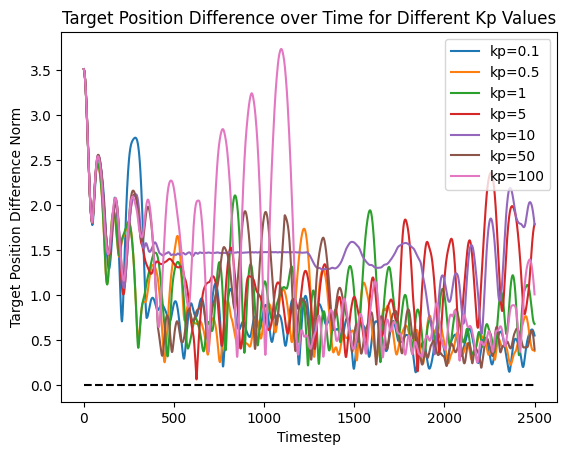

In [15]:
class TargetDiffCallback:
    def __init__(self):
        self.target_diffs = []

    def __call__(self, model, data, policy):
        # Store the relevant information in the target_diffs list
        target_diff = np.linalg.norm(data.qpos[policy.qpos_idx] - policy.target_qpos)
        self.target_diffs.append(target_diff)

import matplotlib.pyplot as plt

p_diffs_data = {}
for i in [0.1, 0.5, 1, 5, 10, 50, 100]:
    cb = TargetDiffCallback()
    home_config_policy = ProportionalJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=i
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    p_diffs_data[i] = cb.target_diffs

for i in p_diffs_data:
    plt.plot(p_diffs_data[i], label=f'kp={i}')

plt.hlines(0, 0, len(p_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Kp Values')
plt.legend()
plt.show()

Note that for $kp=10$, the robot converges nicely toward the target, but seems to fall short. For $kp=1000$ The robot oscilates wildly around the target configuration. For $kp=100$, the robot converges very close to the target configuration, but with slight overshooting.

While $kp=100$ seems to be the best choice among the three, we cannot allow any overshooting so that our motion plan executions are safe. Overshooting means that the robot reaches the target at high speeds, which can lead to collisions with obstacles. So how can we fix this?

## PID Control

PID stands for Proportional-Integral-Derivative control. It is an extension of the proportional controller that we have already implemented. The idea is to add two more terms to the control signal to improve performance:
1. **Integral Term**: The integral of the error accounts for the accumulation of past errors. It helps eliminate steady-state errors that may occur with a pure proportional controller.
2. **Derivative Term**: The derivative of the error predicts future errors based on the current rate of change of the error. It helps dampen the system's response and reduce overshooting.

The control signal for a PID controller at time $t$ is given by:
$$
u(t) = kp \cdot e(t) + ki \cdot \int_0^t e(\tau) d\tau + kd \cdot \frac{\partial}{\partial t} e(t)
$$

We already know how to calculate the error term:
$$
e(t) = r - q(t)
$$
Where $r$ is the reference (target configuration) and $q(t)$ is the robot configuration at time $t$.

The derivative of the error is calculated as follows:
$$
\frac{\partial}{\partial t} e(t)= \frac{\partial}{\partial t} (r - q(t)) = -\frac{\partial}{\partial t} q(t) = -v(t)
$$
Where $v(t)$ is the current joint velocities at time $t$.

The integral of the error is calculated as follows:
$$
\int_0^t e(\tau) d\tau \approx \sum_{i=0}^{n} e(t_i) \Delta t
$$

Let's start by getting the velocity indices for the robot. These are equivalent to the degrees of freedom for the UR5e robot:

In [16]:
def get_entity_qvel_idx(model: mujoco.MjModel, prefix: str = "") -> list[int]:
    return [model.joint(i).dofadr[0] for i in range(model.njnt) 
            if model.joint(i).name.startswith(prefix)]

Now, implement the PID controller:

In [19]:
class PIDJointPositionControlPolicy(Policy):
    def __init__(
        self,
        model: mujoco.MjModel,
        target_qpos: np.ndarray,
        kp: float,
        ki: float,
        kd: float,
    ):
        """
        A PID controller in joint space for configuration control.

        Args:
            model (mujoco.MjModel): MuJoCo model.
            target_qpos (np.ndarray): Target joint configuration (shape: [6] for UR5e).
            kp (float): Proportional gain.
            ki (float): Integral gain.
            kd (float): Derivative gain.
        """
        super().__init__(model)
        self.target_qpos = target_qpos
        self.kp = kp
        self.ki = ki
        self.kd = kd

        # Initialize integral error accumulator
        self.integral_error = np.zeros_like(target_qpos)

        self.qpos_idx = get_entity_qpos_idx(model, prefix="robot_")
        self.qvel_idx = get_entity_qvel_idx(model, prefix="robot_")
        self.ctrl_idx = get_entity_ctrl_idx(model, prefix="robot_")

    def set_control(self, data: mujoco.MjData):
        """
        Compute joint position commands to drive the robot to the target configuration.
        """
        dt = self.model.opt.timestep

        # Get current joint positions and velocities (UR5e = last 6 joints)
        current_qpos = data.qpos[self.qpos_idx]
        current_qvel = data.qvel[self.qvel_idx]

        # Compute position error
        q_error = self.target_qpos - current_qpos

        # Update integral of error
        self.integral_error += q_error * dt

        # Compute derivative of error (can also use -current_qvel directly)
        q_error_dot = -current_qvel

        # PID control law (in torque)
        torque_desired = (
            self.kp * q_error + self.ki * self.integral_error + self.kd * q_error_dot
        )

        # Set control inputs (assuming velocity control)
        data.ctrl[self.ctrl_idx] = torque_desired

## Understanding PID Gains

The proportional gain is fairly straightforward: it is the proportion of the error that we use as the desired velocity. Now, let's understand the role of the derivative term and its gain.

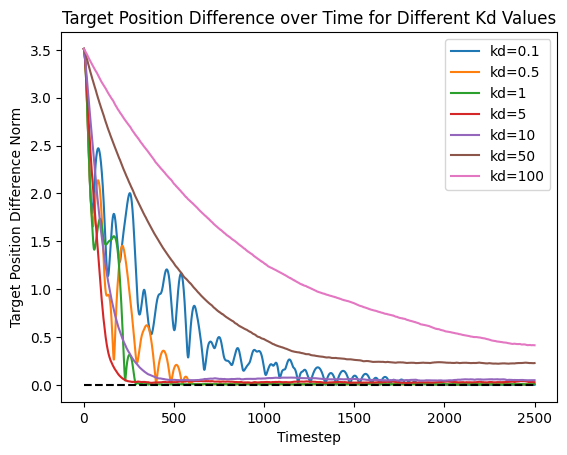

In [20]:
pd_diffs_data = {}
for i in [0.1, 0.5, 1, 5, 10, 50, 100]:
    cb = TargetDiffCallback()
    home_config_policy = PIDJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=50, ki=0, kd=i
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    pd_diffs_data[i] = cb.target_diffs

for i in pd_diffs_data:
    plt.plot(pd_diffs_data[i], label=f'kd={i}')

plt.hlines(0, 0, len(pd_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Kd Values')
plt.legend()
plt.show()

The derivative term is a form of damping. It adds a velocity that is opposite to the current velocity, scaled by the derivative gain. This means that if the robot is moving quickly towards the target, the derivative term will apply a strong opposing velocity to slow it down. Conversely, if the robot is moving slowly, the opposing velocity will be smaller. Higher gains mean stronger damping effects.

With gain $kd=1$, The robot converges to the target, but not very smoothly. This is because the damping effect is too weak to counteract the momentum of the robot as it approaches the target configuration. With $kd=100$, the robot converges very smoothly but far from the target. This is because the damping effect is too strong, preventing the robot from reaching the target configuration effectively. With $kd=10$, we achieve a good balance: the robot converges to the target smoothly without overshooting. However, we can see that the robot is not quite reaching the target configuration.

Now let's understand the integral term and its gain.

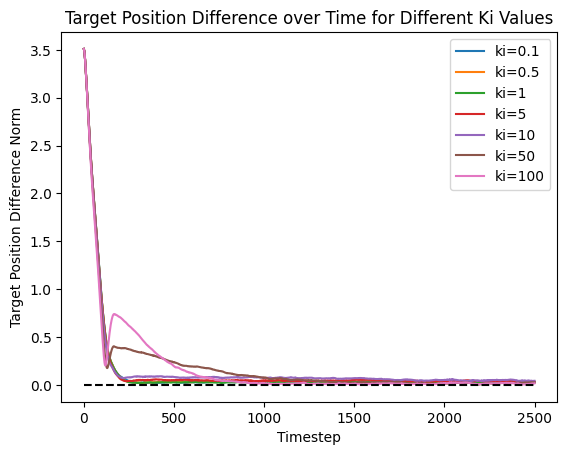

In [22]:
pid_diffs_data = {}
for i in [0.1, 0.5, 1, 5, 10, 50, 100]:
    cb = TargetDiffCallback()
    home_config_policy = PIDJointPositionControlPolicy(
        model, target_qpos=HOME_CONFIG,
        kp=50, ki=i, kd=5
    )

    # set framerate to 0 to skip rendering during data collection
    run_and_render_policy(model, data, home_config_policy, duration=5.0, framerate=0, callback=cb)
    pid_diffs_data[i] = cb.target_diffs

for i in pid_diffs_data:
    plt.plot(pid_diffs_data[i], label=f'ki={i}')

plt.hlines(0, 0, len(pid_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Ki Values')
plt.legend()
plt.show()

In [26]:
from tqdm.auto import tqdm
pbar = tqdm(total=7*7*7)
full_pid_diffs_data = {}
for kp in [0.1, 0.5, 1, 5, 10, 50, 100]:
    for ki in [0.1, 0.5, 1, 5, 10, 50, 100]:
        for kd in [0.1, 0.5, 1, 5, 10, 50, 100]:
            cb = TargetDiffCallback()
            home_config_policy = PIDJointPositionControlPolicy(
                model, target_qpos=HOME_CONFIG,
                kp=kp, ki=ki, kd=kd
            )

            # set framerate to 0 to skip rendering during data collection
            run_and_render_policy(model, data, home_config_policy, duration=20.0, framerate=0, callback=cb)
            full_pid_diffs_data[(kp, ki, kd)] = cb.target_diffs
            pbar.update(1)

  0%|          | 0/343 [00:00<?, ?it/s]

Best parameters: Kp=50, Ki=1, Kd=5 with min diff 0.026689202708931648 at time 254


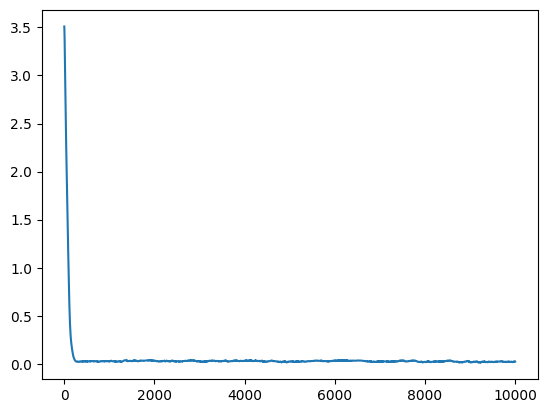

In [27]:
min_val = (float('inf'), float("inf"))
best_params = None
for params, diffs in full_pid_diffs_data.items():
    min_diff = min_diff_time = prev_diff = float('inf')
    for i in range(len(diffs)):
        if diffs[i] > prev_diff:
            break  # Stop checking if the sequence is no longer monotonic
        prev_diff = diffs[i]
        if diffs[i] < min_diff:
            min_diff = diffs[i]
            min_diff_time = i

    if (min_diff, min_diff_time) < min_val:
        min_val = (min_diff, min_diff_time)
        best_params = params

best_kp, best_ki, best_kd = best_params
min_diff, min_time = min_val

plt.plot(full_pid_diffs_data[best_params], label=f'Kp={best_kp}, Ki={best_ki}, Kd={best_kd}')
print(f"Best parameters: Kp={best_kp}, Ki={best_ki}, Kd={best_kd} with min diff {min_diff} at time {min_time}")

The integral term helps eliminate steady-state errors. If the robot is consistently falling short of the target configuration, the integral term will accumulate this error over time and apply a velocity that pushes the robot closer to the target. Higher gains mean that the integral term will have a stronger effect on the control signal.

Let's compare the three controllers we have implemented so far: proportional, PD, and PID:

KeyError: 595

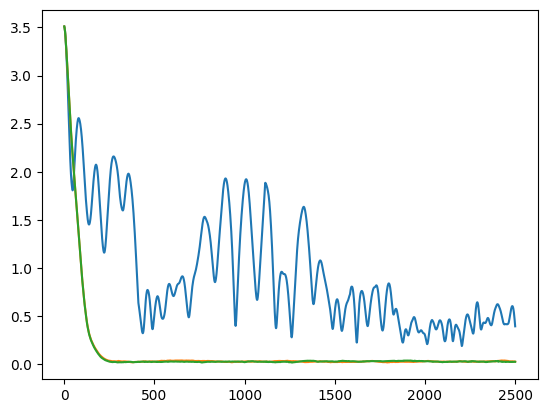

In [28]:
plt.plot(p_diffs_data[best_kp], label='p-only')
plt.plot(pd_diffs_data[best_kd], label='pd')
plt.plot(pid_diffs_data[best_ki], label='pid')

plt.hlines(0, 0, len(pid_diffs_data[i]), colors='k', linestyles='dashed')
plt.xlabel('Timestep')
plt.ylabel('Target Position Difference Norm')
plt.title('Target Position Difference over Time for Different Ki Values')
plt.legend()
plt.show()

We now have a well-functioning PID controller in configuration space using velocity actuation! It successfully brings us close to the target configuration without overshooting or getting stuck in a steady state before reaching the target. Though the difference between PD and PID controllers may seem subtle in this case, the integral term can be crucial in scenarios where persistent steady-state errors occur due to factors like friction or external disturbances. The integral component helps to correct these errors over time, ensuring that the system reaches and maintains the desired target configuration more accurately.

Let's test out our new PID controller by bringing the robot to the grasping configuration above the red box:

In [29]:
KP = 50
KI = 1
KD = 5

above_box_policy = PIDJointPositionControlPolicy(
    model, target_qpos=above_box_config,
    kp=KP, ki=KI, kd=KD
)
run_and_render_policy(model, data, above_box_policy, duration=2.0, framerate=60)

## Task 2: Motion Planning for Manipulation

In motion planning tutorial, we used the Open Motion Planning Library (OMPL) to bring a robot from a start configuration to a goal configuration while avoiding obstacles. However, this only included static environments where the robot's only task was to navigate from point A to point B (in C-space). In manipulation tasks, the robot explicit goal is to interact with objects, thus changing the environment.

We can view our manipulation task as a sequence of motion planning problems. This problem is often referred to as **task and motion planning (TAMP)**, where the higher-level task is treated as a separate discrete planning problem. We will cover TAMP in more detail later in the course. For now, let's manually break down our pick-and-place task:
1. Move from initial configuration to home configuration
2. Move from home configuration to pre-grasp configuration (e.g., above the red box)
3. Move from pre-grasp configuration to grasp configuration (to grab hold of the red box)
4. Move from grasp configuration to pre-grasp configuration (to lift the red box)
5. Move from pre-grasp configuration to place configuration (e.g., above the green bin)
6. Move from place configuration to home configuration

Let's implement the components needed to solve each motion planning problem in the sequence above, step by step.

### Collision Checking in Changing Environments

One thing all the above motion planning problems have in common is the need for collision checking. In the previous motion planning tutorial, we implemented a simple collision checker that checked for collisions between the robot and static obstacles in the environment. However, in our pick-and-place task, we have movable obstacles (the red box and green bin) that change position as the robot interacts with them.

To account for the changing environment, we need a parameterized collision checker that changes which obstacles to check for collisions based on the current step in the manipulation sequence. We differentiate between three kinds of bodies in the environment:
1. **Controlled Bodies**: the object for which we are planning the motion.
2. **Obstacles**: all other objects in the environment that the robot must avoid colliding with.
3. **Attached bodies**: bodies that are allowed to be in contact (e.g., the gripper and the red box when grasping).

Let's implement a parameterized collision checker that takes in the moving body and colliding bodies as parameters:

In [30]:
def is_collision_state(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
) -> bool:
    # Check for collision between robot and environment
    # do not count collision between objects and themselves
    for i in range(data.ncon):
        # get contact info
        contact = data.contact[i]

        # get the names of the bodies involved in the contact
        geom1_body_id = model.geom(contact.geom1).bodyid[0]
        geom1_body_name = model.body(geom1_body_id).name
        geom2_body_id = model.geom(contact.geom2).bodyid[0]
        geom2_body_name = model.body(geom2_body_id).name

        # skip if the geoms are pairs to be excluded
        # check both that neither (A,B) and (B,A) are in the exclude list
        excluded_body_collision = any(
            (geom1_body_name.startswith(prefix1) and geom2_body_name.startswith(prefix2))
            or (geom1_body_name.startswith(prefix2) and geom2_body_name.startswith(prefix1)
            ) for (prefix1, prefix2) in exclude_collision_prefix_pairs
        )

        if excluded_body_collision:
            continue  # excluded collision pair. skip contact

        # check if the collision involves any moving body
        moving_body_collision = any(
            geom1_body_name.startswith(prefix) or geom2_body_name.startswith(prefix)
            for prefix in controlled_bodies_prefix
        )
        if moving_body_collision:
            return True  # Collision detected

    return False  # No collision detected

In [31]:
# TODO add some test configurations

tst1 = [
    -0.9248466731442233,
    -0.5779528441494264,
    0.43236819710290453,
    -0.5585175776967425,
    -0.947342378572742,
    0.3641482616857987,
]

### Grasping Configurations

Why do we require a pre-grasp AND a grasp configuration? The pre-grasp configuration allows the robot to approach the object from a safe distance, reducing the risk of collisions with the object or surrounding obstacles. It also provides a controlled approach path, which is essential for precise manipulation tasks. The grasp configuration is where the robot actually makes contact with the object to be manipulated. By separating these two configurations, we can ensure that the robot can position itself accurately before executing the grasp, leading to more reliable and successful manipulation.

We already found one pre-grasp configuration above the red box using IK, saved in the `above_block_pos` and `above_block_rot_mat` variables. However, there is another configuration above the red box that we can use:

In [32]:
mujoco.mj_resetData(model, data)

# above_block_rot_mat2 = np.array([[-1, 0,  0],
#                                  [ 0, 1,  0],
#                                  [ 0, 0, -1]])

above_block_rot_mat2 = np.array([[1,  0,  0],
                                 [0, -1,  0],
                                 [0,  0, -1]])

box_ik_solutions2 = compute_ik(above_block_pos, above_block_rot_mat2)

@interact(ik_solution_number=(0, len(box_ik_solutions2)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(ik_solution_number, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot") ] = box_ik_solutions2[ik_solution_number]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())

interactive(children=(IntSlider(value=3, description='ik_solution_number', max=7), Dropdown(description='camer…

There are four more possible pre-grasp configurations, one for each side of the box. In the general case, we would like to evaluate all possible grasping configurations to find the best one. For simplicity, we will only consider the two configurations above the box for this assignment.

We now need to select a grasp configuration. There are many considerations in this selection process, including:
1. **Stability**: will the robot be able to hold onto the object securely?
2. **Reachability**: can the robot reach the grasp configuration without colliding with obstacles?
3. **Task Requirements**: does the grasp configuration allow the robot to perform the subsequent manipulation tasks effectively?

The above grasp quality measures are typically combined into a single "ranking pipeline". However, for simplicity, we will use a simple heuristic: Choose the closest configuration to the robot's current configuration (Euclidean) that is not in collision with any obstacles. Here, we make the assumption that Euclidean distance in configuration space is a reasonable proxy for the actual effort required to move between configurations, and that the target configuration is reachable.

Let's implement this function and select a pre-grasp configuration. Remember, We can compute IK efficiently using our analytical solver, and collision detection is relatively expensive.

Selected pre-grasp configuration: [ 1.36148811 -1.41872603 -2.42397773 -0.86968522  1.57079633 -0.20930821]


""

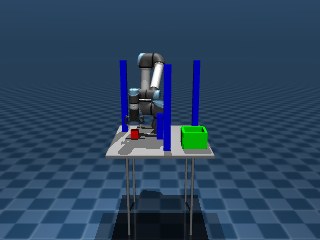

In [33]:
def select_pose_configuration(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    grasp_poses: list[tuple[np.ndarray, np.ndarray]],
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
) -> np.ndarray | None:
    ik_solutions = []

    # Get all ik solutions for each grasp pose
    for pos, rot_mat in grasp_poses:
        ik_solutions.extend(compute_ik(pos, rot_mat))

    # sort solutions according to distance from the current configuration
    robot_qpos_idx = get_entity_qpos_idx(model, "robot")
    current_qpos = data.qpos[robot_qpos_idx]
    ik_solutions.sort(key=lambda sol: np.linalg.norm(sol - current_qpos))

    # return the first collision-free solution
    for sol in ik_solutions:
        data.qpos[robot_qpos_idx] = sol
        mujoco.mj_forward(model, data)

        if not is_collision_state(
            model,
            data,
            controlled_bodies_prefix=controlled_bodies_prefix,
            exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
        ):
            return sol  # collision-free solution found

    return None  # no collision-free solution found


pre_grasp_poses = [
    (above_block_pos, above_block_rot_mat),
    (above_block_pos, above_block_rot_mat2),
]

mujoco.mj_resetData(model, data)
selected_pre_grasp_config = select_pose_configuration(
    model,
    data,
    pre_grasp_poses,
    controlled_bodies_prefix=["robot_", "gripper_"],
    exclude_collision_prefix_pairs=[("gripper_", "red_box")],
)
if selected_pre_grasp_config is not None:
    print("Selected pre-grasp configuration:", selected_pre_grasp_config)
    data.qpos[get_entity_qpos_idx(model, "robot")] = selected_pre_grasp_config
    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera="frontview")
        media.show_image(renderer.render())

Using the same logic, let's find a grasp configuration. This corresponds to poses identical to the pre-grasp configurations, but lowered down to the top of the red box.

Selected grasp configuration: [ 1.36148811 -1.55263829 -2.49145682 -0.66829388  1.57079633 -0.20930821]


""

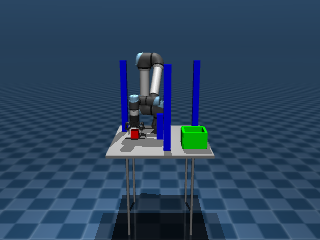

In [34]:
on_block_pos = above_block_pos - np.array([0, 0, 0.05])
grasp_poses = [
    (on_block_pos, above_block_rot_mat),
    (on_block_pos, above_block_rot_mat2),
]

selected_grasp_config = select_pose_configuration(
    model, data, grasp_poses, controlled_bodies_prefix=["robot_", "gripper_"]
)
if selected_grasp_config is not None:
    print("Selected grasp configuration:", selected_grasp_config)
    data.qpos[get_entity_qpos_idx(model, "robot")] = selected_grasp_config
    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera="frontview")
        media.show_image(renderer.render())

To lower the end-effector from the pre-grasp configuration to the grasp configuration, we will take a leap of faith and assume that a straight-line motion in C-space is collision-free. This way, we can use our PID controller to move the end-effector between the two configurations. However, this is not always the case, requiring additional motion planning. We will ignore this for now.

In [35]:
mujoco.mj_resetData(model, data)
data.qpos[get_entity_qpos_idx(model, "robot")] = selected_pre_grasp_config
mujoco.mj_forward(model, data)

go_to_grasp_policy = PIDJointPositionControlPolicy(
    model, target_qpos=selected_grasp_config,
    kp=KP, ki=KI, kd=KD
)

duration= 1.0 # seconds
framerate = 60  # frames per second

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        go_to_grasp_policy.set_control(data)

        mujoco.mj_step(model, data)

        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="frontview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

### Gripper Usage

The gripper attached to the robot is a [Robotiq 2F-85](https://www.universal-robots.com/marketplace/products/01tP40000071NgHIAU/) adaptive electric gripper.
- "2F" - refers to the "two-finger" design of the gripper.
- "85" - indicates the maximum opening width of the gripper in millimeters (85 mm).
To control the gripper, we can set the position of the two fingers using the `ctrl` values in the simulation.

While the gripper has many joints that allow for adaptive gripping, it is controlled using a single control signal that sets the opening width of the gripper. This control signal is an integer that ranges from 0 (fully open) to 255 (fully closed). The reason for this is mostly for efficiency: 0-255 can be represented using a single byte, allowing for faster communication between the robot and the controller.

For the purpose of this assignment, we will only use two gripper positions: fully open and fully closed. Let's implement a controller for the gripper:

In [36]:
class GripperControler:
    def __init__(self, model: mujoco.MjModel):
        self.gripper_ctrl_ids = get_entity_ctrl_idx(model, prefix="gripper_")

    def open_gripper(self, data: mujoco.MjData):
        data.ctrl[self.gripper_ctrl_ids] = [0.0]
    
    def close_gripper(self, data: mujoco.MjData):
        data.ctrl[self.gripper_ctrl_ids] = [255]

We need to ensure that the robot is stationary when operating the gripper. Let's implement a policy that does this:

In [37]:
class StayInPlacePolicy(PIDJointPositionControlPolicy):
    def __init__(self, model: mujoco.MjModel):
        # set dummy target to the initial robot configuration
        # this is required to initialize the parent class
        qpos0_robot = model.qpos0[get_entity_qpos_idx(model, "robot")]
        super().__init__(model, qpos0_robot, KP, KI, KD)

        # remove target_qpos as a sign that we want to get it from the data
        self.target_qpos = None


    def set_control(self, data: mujoco.MjData):
        if self.target_qpos is None:
            self.target_qpos = data.qpos[get_entity_qpos_idx(self.model, "robot")]

        super().set_control(data)

Let's write a short script to test out our gripper controller:

In [38]:
mujoco.mj_resetData(model, data)
gripper_controller = GripperControler(model)
stay_in_place_policy = StayInPlacePolicy(model)

data.qpos[get_entity_qpos_idx(model, "robot")] = selected_grasp_config
mujoco.mj_forward(model, data)

go_to_pregrasp_policy = PIDJointPositionControlPolicy(
    model, target_qpos=selected_pre_grasp_config,
    kp=KP, ki=KI, kd=KD
)

gripper_controller.close_gripper(data)

grip_duration= 1.0 # seconds
framerate = 60  # frames per second
lift_duration = 2.0  # seconds

frames = []
with mujoco.Renderer(model) as renderer:
    while data.time < grip_duration + lift_duration:
        if data.time < grip_duration:
            stay_in_place_policy.set_control(data)
            gripper_controller.close_gripper(data)
        else:
            go_to_pregrasp_policy.set_control(data)

        mujoco.mj_step(model, data)

        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="leftsideview")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

### Motion Planner Setup

We are ready to implement the full pick-and-place task execution pipeline! Let's break it down step by step.

In [39]:
!pip install ompl

We start by defining the state space for the motion planner. This includes the robot's configuration limits. In the motion planning tutorial, we simply accepted the limits as is. However, we can apply a simple trick to reduce the size of the state space and improve planning times. Note that the UR5e robot has joint limits that allow for multiple full rotations of some joints. While this can be useful in practice, we can achieve any desired end-effector pose using a single rotation of each joint, which is enough for our task. Therefore, we can tighten the joint limits to reduce the size of the state space without losing any reachable end-effector poses.

In [40]:
def get_clipped_joint_bounds(model: mujoco.MjModel) -> list[tuple[float, float]]:
    bounds = []
    for i in range(model.njnt):
        joint = model.joint(i)
        if not joint.name.startswith("robot"):
            continue
        clipped_range = np.clip(joint.range, -np.pi, np.pi)

        bounds.append((clipped_range[0], clipped_range[1]))
    return bounds

get_clipped_joint_bounds(model)

[(np.float64(-3.141592653589793), np.float64(3.141592653589793)),
 (np.float64(-3.141592653589793), np.float64(3.141592653589793)),
 (np.float64(-3.1415), np.float64(3.1415)),
 (np.float64(-3.141592653589793), np.float64(3.141592653589793)),
 (np.float64(-3.141592653589793), np.float64(3.141592653589793)),
 (np.float64(-3.141592653589793), np.float64(3.141592653589793))]

Let's define the state space with tightened joint limits:

In [41]:
from ompl import base as ob

def get_ur5e_state_space() -> ob.RealVectorStateSpace:
    space = ob.RealVectorStateSpace(6)  # 6 DOFs for UR5e

    # initialize a bounds object
    bounds = ob.RealVectorBounds(6)

    # iterate discovered joint bounds and set them in the bounds object
    joint_bounds = get_clipped_joint_bounds(model)
    for i in range(6):
        low, high = joint_bounds[i]
        bounds.setLow(i, low)
        bounds.setHigh(i, high)

    # add the bounds to the state space
    space.setBounds(bounds)

    return space

Now let's implement a function that gives us the state space info object.

In [42]:
def get_state_space_info(
    model: mujoco.MjModel,
    data: mujoco.MjData,
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
    check_resolution: float = 0.01,
) -> ob.SpaceInformation:
    # instantiate on our C-space
    state_info = ob.SpaceInformation(get_ur5e_state_space())

    def validity_checker(state: ob.State) -> bool:
        # set the robot joint positions from the state
        for i, idx in enumerate(get_entity_qpos_idx(model, "robot")):
            data.qpos[idx] = state[i]
        mujoco.mj_forward(model, data)

        # check for collision
        return not is_collision_state(
            model, data,
            controlled_bodies_prefix=controlled_bodies_prefix,
            exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
        )

    state_info.setStateValidityChecker(ob.StateValidityCheckerFn(validity_checker))

    state_info.setStateValidityCheckingResolution(check_resolution)

    return state_info

In [43]:
def get_mp_problem(
    state_info: ob.SpaceInformation,
    start_q: np.ndarray,
    goal_q: np.ndarray,
    goal_threshold: float,
) -> ob.ProblemDefinition:
    # create a problem definition
    pdef = ob.ProblemDefinition(state_info)

    # create start state
    start_state = ob.State(state_info.getStateSpace())
    for i in range(6):
        start_state[i] = start_q[i]

    # create goal state
    goal_state = ob.State(state_info.getStateSpace())
    for i in range(6):
        goal_state[i] = goal_q[i]

    # set start and goal states
    pdef.setStartAndGoalStates(start_state, goal_state, goal_threshold)

    return pdef

In [44]:
import ompl.geometric as og


def get_rrtstar_planner(
    start_q: np.ndarray,
    goal_q: np.ndarray,
    model: mujoco.MjModel,
    data: mujoco.MjData,
    controlled_bodies_prefix: list[str],
    exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
    check_resolution: float = 0.01,
    goal_threshold: float = 0.01,
) -> list[np.ndarray] | None:
    state_info = get_state_space_info(
        model, data,
        controlled_bodies_prefix=controlled_bodies_prefix,
        exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
        check_resolution=check_resolution,
    )
    pdef = get_mp_problem(state_info, start_q, goal_q, goal_threshold)

    # initialize the planner
    planner = og.RRTstar(state_info)

    # set the maximum step size between two states
    # smaller values lead to a denser tree but slower performance
    planner.setRange(0.5)

    # configure the planner with the problem definition
    planner.setProblemDefinition(pdef)

    # finalize the planner setup
    planner.setup()

    return planner

In [45]:
import sys

def plan_motion(planner: ob.Planner, time_limit: float = 5.0, interpolate: int = 0) -> list[np.ndarray] | None:
    solved = planner.solve(time_limit)
    sys.stdout.flush()  # flush output to ensure logs are printed before proceeding

    if solved.getStatus() == ob.PlannerStatus.EXACT_SOLUTION:
        print("Found exact solution.")
    elif solved.getStatus() == ob.PlannerStatus.APPROXIMATE_SOLUTION:
        print("Found approximate solution.")
    else:
        print("No solution found.")

    waypoints = []

    path = planner.getProblemDefinition().getSolutionPath()
    print("number of waypoints in solution:", path.getStateCount())

    # optional: interpolate the waypoints for smoother path
    if interpolate > 0:
        path.interpolate(interpolate)

    # extract the waypoints from the path
    for i in range(path.getStateCount()):
        state = path.getState(i)
        waypoint = [state[j] for j in range(6)]
        waypoints.append(waypoint)
    
    return waypoints, solved.getStatus()

In [46]:
mujoco.mj_resetData(model, data)  # Reset state and time.

planner = get_rrtstar_planner(
    start_q = [0, 0, 0, 0, 0, 0],
    goal_q = HOME_CONFIG,
    model=model,
    data=data,
    controlled_bodies_prefix=["robot_", "gripper_"],
    check_resolution=0.01
)

waypoints, status = plan_motion(planner, time_limit=5.0)#, interpolate=100)

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 8.70 in 502 iterations (320 vertices in the graph)
Info:    RRTstar: Created 4396 new states. Checked 9427709 rewire options. 1 goal states in tree. Final solution cost 8.699
Found exact solution.
number of waypoints in solution: 19


In [47]:
mujoco.mj_resetData(model, data)

@interact(wp_id=(0, len(waypoints)-1), camera=["leftsideview", "rightsideview", "frontview", "birdview", "leftangleview", "rightangleview"])
def render_ik_solution(wp_id, camera="leftsideview"):
    data.qpos[get_entity_qpos_idx(model, "robot") ] = waypoints[wp_id]  # apply one of the IK solutions
    mujoco.mj_forward(model, data)  # Update the simulation state
    with mujoco.Renderer(model) as renderer:
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render())
        print('collision detected:', is_collision_state(
            model, data,
            controlled_bodies_prefix=["robot_", "gripper_"],
        ))

interactive(children=(IntSlider(value=9, description='wp_id', max=18), Dropdown(description='camera', options=…

### Task Execution Policy

It is now time to put everything together into a single policy that executes the full pick-and-place task. We will implement this as a sequential state machine, where each state corresponds to a step in the manipulation sequence outlined earlier.

In [48]:
from tqdm.auto import tqdm


class PolicySMNode(ABC):
    @abstractmethod
    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        pass

    @abstractmethod
    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        pass


class SMPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, nodes: list[PolicySMNode]):
        super().__init__(model)
        self.nodes = nodes
        self.cur_node_idx = 0
        self.cur_policy = None
        self.pbar = tqdm(total=len(nodes), desc="State Machine Progress", unit="node")
    
    def set_control(self, data: mujoco.MjData):
        if self.is_complete:
            return # no current node set

        if self.cur_policy is None:
            self.cur_policy = self.nodes[self.cur_node_idx].get_policy(self.model, data)

        self.cur_policy.set_control(data)

        if self.nodes[self.cur_node_idx].is_complete(self.model, data):
            self.cur_node_idx += 1
            self.cur_policy = None  # reset current policy for the new node
            self.pbar.update(1)

    @property
    def is_complete(self) -> bool:
        return self.cur_node_idx >= len(self.nodes)

In [49]:
class GoToConfigSMNode(PolicySMNode, ABC):
    def __init__(
        self,
        target_config: np.ndarray,
        goal_tolerance: float = 0.01,
    ):
        self.goal_tolerance = goal_tolerance
        self.target_config = target_config

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        return PIDJointPositionControlPolicy(
            model, target_qpos=self.target_config, kp=KP, ki=KI, kd=KD
        )

    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        robot_qpos_idx = get_entity_qpos_idx(model, "robot")
        current_qpos = data.qpos[robot_qpos_idx]
        return np.linalg.norm(current_qpos - self.target_config) < self.goal_tolerance

In [50]:
class MotionPlanPolicy(SMPolicy):
    def __init__(
        self,
        model: mujoco.MjModel,
        waypoints: list[np.ndarray],
        goal_tolerance: float = 0.01,
    ):
        nodes = [GoToConfigSMNode(target_config=wp, goal_tolerance=goal_tolerance) for wp in waypoints]
        super().__init__(model, nodes)

In [51]:
mp_policy = MotionPlanPolicy(
    model, waypoints,
    goal_tolerance=5e-2,
)

run_and_render_policy(model, data, mp_policy, duration=10.0, framerate=60, camera="frontview")    

State Machine Progress:   0%|          | 0/19 [00:00<?, ?node/s]

In [65]:
class MotionPlanToConfigSMNode(PolicySMNode):
    def __init__(
        self,
        goal_q: np.ndarray,
        controlled_bodies_prefix: list[str],
        exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
        check_resolution: float = 0.01,
        goal_threshold: float = 0.01,
        goal_tolerance: float = 0.1,
        planning_time_limit: float = 5.0,
        expected_status: ob.PlannerStatus = ob.PlannerStatus.EXACT_SOLUTION,
        max_planning_retries: int = 5,
        reset_planning_on_retry: bool = True,
        plan_interpolate: int = 0,
    ):
        self.goal_q = goal_q
        self.controlled_bodies_prefix = controlled_bodies_prefix
        self.exclude_collision_prefix_pairs = exclude_collision_prefix_pairs
        self.check_resolution = check_resolution
        self.goal_threshold = goal_threshold
        self.goal_tolerance = goal_tolerance
        self.planning_time_limit = planning_time_limit
        self.expected_status = expected_status
        self.max_planning_retries = max_planning_retries
        self.reset_planning_on_retry = reset_planning_on_retry
        self.plan_interpolate = plan_interpolate

        self.mp_policy = None

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        robot_qpos_idx = get_entity_qpos_idx(model, "robot")
        start_q = data.qpos[robot_qpos_idx]

        # make a copy of data to avoid modifying the original data during planning
        data_mp_copy = deepcopy(data)

        planner = get_rrtstar_planner(
            start_q=start_q,
            goal_q=self.goal_q,
            model=model,
            data=data_mp_copy,
            controlled_bodies_prefix=self.controlled_bodies_prefix,
            exclude_collision_prefix_pairs=self.exclude_collision_prefix_pairs,
            check_resolution=self.check_resolution,
        )

        for i in range(self.max_planning_retries):
            if self.reset_planning_on_retry:
                planner.clear()

            waypoints, status = plan_motion(
                planner,
                time_limit=self.planning_time_limit,
                interpolate=self.plan_interpolate
            )
            if status == self.expected_status:
                break  # successful planning
            elif i < self.max_planning_retries - 1:
                print(f'Solution status: {status}, resuming motion planning...')
            else:
                print(f'Solution status: {status}, maximum planning retries reached. Contnuing with approximate plan')
                waypoints.append(self.goal_q)  # add goal as last waypoint

        self.mp_policy = MotionPlanPolicy(
            model,
            waypoints,
            goal_tolerance=self.goal_tolerance,
        )

        return self.mp_policy

    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        return self.mp_policy is not None and self.mp_policy.is_complete

In [66]:
class MotionPlanToPoseSMNode(MotionPlanToConfigSMNode):
    def __init__(
        self,
        goal_poses: list[tuple[np.ndarray, np.ndarray]],
        controlled_bodies_prefix: list[str],
        exclude_collision_prefix_pairs: list[tuple[str, str]] = [],
        check_resolution: float = 0.01,
        goal_threshold: float = 0.01,
        goal_tolerance: float = 0.1,
        planning_time_limit: float = 5.0,
        expected_status: ob.PlannerStatus = ob.PlannerStatus.EXACT_SOLUTION,
        max_planning_retries: int = 5,
        reset_planning_on_retry: bool = True,
        plan_interpolate: int = 0,
    ):
        super().__init__(
            goal_q=None,  # will be set later
            controlled_bodies_prefix=controlled_bodies_prefix,
            exclude_collision_prefix_pairs=exclude_collision_prefix_pairs,
            check_resolution=check_resolution,
            goal_threshold=goal_threshold,
            goal_tolerance=goal_tolerance,
            planning_time_limit=planning_time_limit,
            expected_status=expected_status,
            max_planning_retries=max_planning_retries,
            reset_planning_on_retry=reset_planning_on_retry,
            plan_interpolate=plan_interpolate,
        )
        self.goal_poses = goal_poses

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        data_pose_selector_copy = deepcopy(data)
        selected_config = select_pose_configuration(
            model,
            data_pose_selector_copy,
            self.goal_poses,
            controlled_bodies_prefix=self.controlled_bodies_prefix,
            exclude_collision_prefix_pairs=self.exclude_collision_prefix_pairs,
        )
        if selected_config is None:
            raise RuntimeError(
                "No collision-free IK solution found for the given goal poses."
            )
        self.goal_q = selected_config
        return super().get_policy(model, data)

In [67]:
# midway_policy = SMPolicy(
#     model,
#     nodes=[
#         MotionPlanToConfigSMNode(
#             goal_q=HOME_CONFIG,
#             controlled_bodies_prefix=["robot_", "gripper_"],
#             plan_interpolate=100,
#         ),
#         MotionPlanToPoseSMNode(
#             goal_poses=pre_grasp_poses,
#             controlled_bodies_prefix=["robot_", "gripper_"],
#             plan_interpolate=100,
#         ),
#         MotionPlanToPoseSMNode(
#             goal_poses=grasp_poses,
#             controlled_bodies_prefix=["robot_", "gripper_"],
#         ),
#     ],
# )

# run_and_render_policy(model, data, midway_policy, duration=15.0, framerate=60, camera="frontview")

In [68]:
class DurationConfigSMNode(PolicySMNode, ABC):
    def __init__(
        self,
        policy: Policy,
        duration: float,
    ):
        self.policy = policy
        self.duration = duration
        self.start_time = None

    def get_policy(self, model: mujoco.MjModel, data: mujoco.MjData) -> Policy:
        if self.start_time is None:
            self.start_time = data.time
        return self.policy

    def is_complete(self, model: mujoco.MjModel, data: mujoco.MjData) -> bool:
        return (data.time - self.start_time) >= self.duration

In [69]:
class GripperControlPolicy(Policy):
    def __init__(self, model: mujoco.MjModel, close: bool):
        super().__init__(model)
        self.close = close
        self.stay_in_place_policy = StayInPlacePolicy(model)
        self.gripper_controller = GripperControler(model)

    def set_control(self, data: mujoco.MjData):
        # set controls for the gripper to open/close
        if self.close:
            self.gripper_controller.close_gripper(data)
        else:
            self.gripper_controller.open_gripper(data)

        # set controls for the robot to stay in place
        self.stay_in_place_policy.set_control(data)

In [70]:
# midway_policy2 = SMPolicy(
#     model,
#     nodes=[
#         MotionPlanToConfigSMNode(
#             goal_q=HOME_CONFIG,
#             controlled_bodies_prefix=["robot_", "gripper_"],
#             plan_interpolate=100,
#         ),
#         MotionPlanToPoseSMNode(
#             goal_poses=pre_grasp_poses,
#             controlled_bodies_prefix=["robot_", "gripper_"],
#             plan_interpolate=100,
#         ),
#         MotionPlanToPoseSMNode(
#             goal_poses=grasp_poses,
#             controlled_bodies_prefix=["robot_", "gripper_"],
#         ),
#         DurationConfigSMNode(
#             policy=GripperControlPolicy(model, close=True),
#             duration=1.0,
#         ),
#         MotionPlanToPoseSMNode(
#             goal_poses=pre_grasp_poses,
#             controlled_bodies_prefix=["robot_", "gripper_", "red_box"],
#             exclude_collision_prefix_pairs=[("gripper_", "red_box")],
#         ),
#         DurationConfigSMNode(
#             policy=StayInPlacePolicy(model),
#             duration=float('inf'),
#         ),
#     ],
# )

# run_and_render_policy(model, data, midway_policy2, duration=20.0, framerate=60, camera="frontview")

In [71]:
above_bin_pos = data.body('green_bin').xpos + np.array([0, 0, 0.3])
above_bin_rot_mat = np.array([[ 0, -1,  0],
                              [-1,  0,  0],
                              [ 0,  0, -1]])
above_bin_rot_mat2 = np.array([[1,  0,  0],
                               [0, -1,  0],
                               [0,  0, -1]])

place_poses = [
    (above_bin_pos, above_bin_rot_mat),
    (above_bin_pos, above_bin_rot_mat2),
]


In [77]:
final_policy = SMPolicy(
    model,
    nodes=[
        # STEP 1: Move to home configuration
        MotionPlanToConfigSMNode(
            goal_q=HOME_CONFIG,
            controlled_bodies_prefix=["robot_", "gripper_"],
            check_resolution=0.005,  # the green bin has narrow walls, use finer resolution
            plan_interpolate=100,
        ),
        # STEP 2: Move to pre-grasp poses
        MotionPlanToPoseSMNode(
            goal_poses=pre_grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_"],
            check_resolution=0.005,  # the green bin has narrow walls, use finer resolution
            plan_interpolate=100,
        ),
        # STEP 3: Move to grasp poses
        MotionPlanToPoseSMNode(
            goal_poses=grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_"],
        ),
        # STEP 3.5: Close gripper to grasp the object
        DurationConfigSMNode(
            policy=GripperControlPolicy(model, close=True),
            duration=0.5,
        ),
        # STEP 4: Move back to pre-grasp poses with the object
        MotionPlanToPoseSMNode(
            goal_poses=pre_grasp_poses,
            controlled_bodies_prefix=["robot_", "gripper_", "red_box"],
            exclude_collision_prefix_pairs=[("gripper_", "red_box")],
        ),
        # STEP 5: Move to above the bin poses
        MotionPlanToPoseSMNode(
            goal_poses=place_poses,
            controlled_bodies_prefix=["robot_", "gripper_", "red_box"],
            exclude_collision_prefix_pairs=[("gripper_", "red_box")],
            check_resolution=0.0005,  # the green bin has narrow walls, use finer resolution
            planning_time_limit=10.0,  # lower resolution may require more planning time
            plan_interpolate=100,
        ),
        # STEP 5.5: Open gripper to release the object
        DurationConfigSMNode(
            policy=GripperControlPolicy(model, close=False),
            duration=1.0,
        ),
        # STEP 6: Move back to home configuration
        MotionPlanToConfigSMNode(
            goal_q=HOME_CONFIG,
            controlled_bodies_prefix=["robot_", "gripper_"],
            plan_interpolate=100,
        ),
        # Stay in place after execution
        DurationConfigSMNode(
            policy=StayInPlacePolicy(model),
            duration=float('inf'),
        ),
    ],
)

run_and_render_policy(model, data, final_policy, duration=40.0, framerate=60, camera="frontview")

State Machine Progress:   0%|          | 0/9 [00:00<?, ?node/s]

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    ProblemDefinition: Adding approximate solution from planner RRTstar
Info:    RRTstar: Created 4114 new states. Checked 8375382 rewire options. 0 goal states in tree. Final solution cost inf
Found approximate solution.
number of waypoints in solution: 25
Solution status: APPROXIMATE_SOLUTION, resuming motion planning...
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 7.11 in 970 iterations (592 vertices in the graph)
Info:    RRTstar: Created 4137 new states. Checked 8460895 rewire options. 1 goal st

State Machine Progress:   0%|          | 0/100 [00:00<?, ?node/s]

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 2.47 in 268 iterations (173 vertices in the graph)
Info:    RRTstar: Created 2644 new states. Checked 3496690 rewire options. 1 goal states in tree. Final solution cost 2.470
Found exact solution.
number of waypoints in solution: 6


State Machine Progress:   0%|          | 0/100 [00:00<?, ?node/s]

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 0.31 in 30 iterations (20 vertices in the graph)
Info:    RRTstar: Created 3331 new states. Checked 5549446 rewire options. 1 goal states in tree. Final solution cost 0.306
Found exact solution.
number of waypoints in solution: 2


State Machine Progress:   0%|          | 0/2 [00:00<?, ?node/s]

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 0.16 in 19 iterations (9 vertices in the graph)
Info:    RRTstar: Created 3353 new states. Checked 5622981 rewire options. 1 goal states in tree. Final solution cost 0.164
Found exact solution.
number of waypoints in solution: 2


State Machine Progress:   0%|          | 0/2 [00:00<?, ?node/s]

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 2.08 in 38 iterations (16 vertices in the graph)
Info:    RRTstar: Created 1020 new states. Checked 520710 rewire options. 1 goal states in tree. Final solution cost 2.083
Found exact solution.
number of waypoints in solution: 6


State Machine Progress:   0%|          | 0/100 [00:00<?, ?node/s]

Info:    RRTstar: Space information setup was not yet called. Calling now.
Info:    RRTstar: No optimization objective specified. Defaulting to optimizing path length for the allowed planning time.
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 2.78 in 42 iterations (37 vertices in the graph)
Info:    RRTstar: Created 3299 new states. Checked 5443350 rewire options. 1 goal states in tree. Final solution cost 2.776
Found exact solution.
number of waypoints in solution: 7


State Machine Progress:   0%|          | 0/100 [00:00<?, ?node/s]

Didn't work? Try again! PID control isn't perfect and may be unstable or inaccurate at times. Furthermore, our motion planner might not find an exact solution every time due to the stochastic nature of these algorithms. In practice, there are more accurate controllers (e.g. [model predictive control](https://en.wikipedia.org/wiki/Model_predictive_control)) as well as parallelized and optimized motion planners to improve tree expansion efficiency (e.g., [cuROBO](https://curobo.org/index.html)). However, these are beyond the scope of this assignment.

## Task 3: Perception with Belief

In [ ]:
#TODO: change where you get the box and bin pose. instead of using the model, use vision
# also need to estimate the uncertainty (Kalman filter).
# also need to estimate the object orientation for EE grasping orientation